### LSTM model - benchmark


In [20]:
!pip install tensorflow-addons

In [43]:
# reference: https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from keras.utils import to_categorical

In [44]:
# read data and run model on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Data Preprocessing

In [114]:
# rescale score from 1-6 to 0-5
df = pd.read_csv('/content/drive/My Drive/6600-project/train.csv')
df['score'] = df['score'] - 1
df.head(5)

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,2
2,001ab80,People always wish they had the same technolog...,3
3,001bdc0,"We all heard about Venus, the planet without a...",3
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",2


In [115]:
test = pd.read_csv('/content/drive/My Drive/6600-project/test.csv')
X_test = test['full_text']


#### Train-validation split

In [116]:
X_train, X_val, y_train, y_val = train_test_split(df['full_text'], df['score'], test_size=0.2, random_state=123)

#### convert y to matrix

In [117]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

#### Hyperparameters & tokenization

In [118]:
max_len = 500
vocab_size = 10000
trunc_type = 'post'
padding_type = 'post'
oov = '<OOV>' # out of vocabulary token
tokenizer = Tokenizer(num_words = vocab_size, char_level = False,oov_token = oov)
tokenizer.fit_on_texts(X_train)
word_to_idx = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen = max_len,padding = padding_type,truncating = trunc_type)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen = max_len,padding = padding_type,truncating = trunc_type)

X_test = tokenizer.texts_to_matrix(X_test)
X_test = pad_sequences(X_test,maxlen = max_len,padding = padding_type,truncating = trunc_type)

#### Build the model

In [119]:
# parameters

embedding_dim = 32
lr = 0.01
#opt = keras.optimizers.Adam(learning_rate=lr)


# model 
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length = max_len)) # embedding layer
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2)) # lstm layer
model.add(Dense(6, activation='softmax')) # dense layer

model.compile(loss = 'categorical_crossentropy', optimizer = "adam" , metrics = [tfa.metrics.CohenKappa(num_classes=6, weightage= 'quadratic' , sparse_labels=False)]) # return crossentropy and qwk

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 500, 32)           320000    
                                                                 
 lstm_11 (LSTM)              (None, 64)                24832     
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
Total params: 345222 (1.32 MB)
Trainable params: 345222 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Add early stopping and train the model

In [120]:
num_epochs = 20

early_stop = EarlyStopping(monitor='val_loss', patience=2)

checkpoint_filepath = './checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = "val_cohen_kappa",
    mode = 'max',
    save_best_only = True
)

def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 10.0
   lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay)

callback_list = [early_stop,model_checkpoint_callback,lr_scheduler]

history = model.fit(X_train,
                    y_train,
                    batch_size = 256,
                    epochs=num_epochs,
                    validation_data=(X_val, y_val),
                    callbacks =callback_list,
                    verbose=2)

Epoch 1/20
55/55 - 80s - loss: 1.3983 - cohen_kappa: 0.2725 - val_loss: 1.3013 - val_cohen_kappa: 0.4254 - lr: 0.0100 - 80s/epoch - 1s/step
Epoch 2/20
55/55 - 75s - loss: 1.2191 - cohen_kappa: 0.5048 - val_loss: 1.2809 - val_cohen_kappa: 0.5211 - lr: 0.0100 - 75s/epoch - 1s/step
Epoch 3/20
55/55 - 74s - loss: 1.0690 - cohen_kappa: 0.6636 - val_loss: 1.1068 - val_cohen_kappa: 0.6483 - lr: 0.0100 - 74s/epoch - 1s/step
Epoch 4/20
55/55 - 73s - loss: 0.9751 - cohen_kappa: 0.7292 - val_loss: 1.0584 - val_cohen_kappa: 0.6677 - lr: 0.0100 - 73s/epoch - 1s/step
Epoch 5/20
55/55 - 73s - loss: 0.9024 - cohen_kappa: 0.7586 - val_loss: 1.0786 - val_cohen_kappa: 0.6992 - lr: 0.0100 - 73s/epoch - 1s/step
Epoch 6/20
55/55 - 74s - loss: 0.8522 - cohen_kappa: 0.7783 - val_loss: 1.1053 - val_cohen_kappa: 0.6543 - lr: 0.0100 - 74s/epoch - 1s/step


#### Visualize the training history

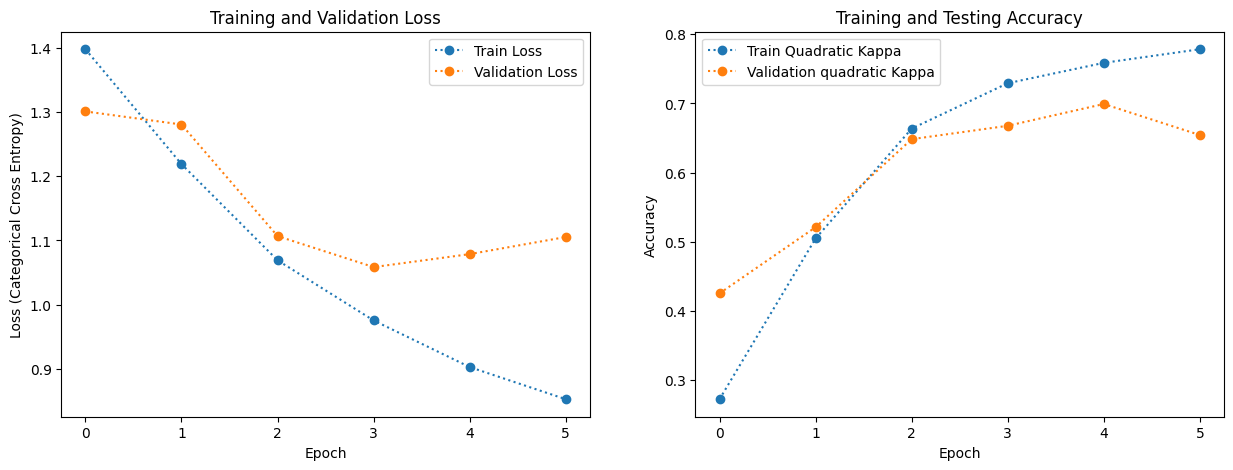

In [121]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

fig = plt.figure(1, figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (Categorical Cross Entropy)')
ax1.plot(hist['epoch'], hist['loss'], label='Train Loss',marker = 'o',linestyle=':')
ax1.plot(hist['epoch'], hist['val_loss'], label='Validation Loss',marker = 'o',linestyle=':')
ax1.legend()

ax2.set_title('Training and Testing Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.plot(hist['epoch'], hist['cohen_kappa'], label='Train Quadratic Kappa',marker = 'o',linestyle=':')
ax2.plot(hist['epoch'], hist['val_cohen_kappa'], label='Validation quadratic Kappa',marker = 'o',linestyle=':')
ax2.legend()
plt.show()

#### Visualize the final result (confusion matrix)

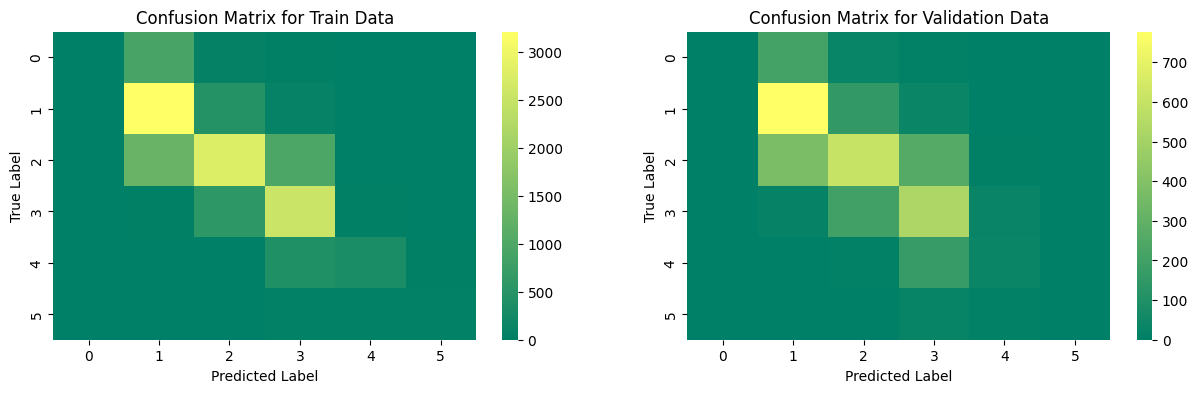

In [122]:
model = keras.models.load_model(checkpoint_filepath)
y_train_pred = model.predict(X_train,verbose = 0)
y_val_pred= model.predict(X_val,verbose = 0)

# print confusion matrix for the best model
def plot_cm(ground_truth,pred_data):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    for i in range(len(ground_truth)):
        sns.heatmap(confusion_matrix(ground_truth[i],pred_data[i]),cmap = 'summer',ax = ax[i])
        ax[i].set_xlabel("Predicted Label")
        ax[i].set_ylabel("True Label")
        ax[0].set_title('Confusion Matrix for Train Data')
        ax[1].set_title('Confusion Matrix for Validation Data')

plot_cm([y_train.argmax(1),y_val.argmax(1)],[y_train_pred.argmax(1),y_val_pred.argmax(1)])

#### Report training & validation QWK for the optimal model

In [123]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-kappa
print(cohen_kappa_score(y_train.argmax(1),y_train_pred.argmax(1),weights = 'quadratic'))
print(cohen_kappa_score(y_val.argmax(1),y_val_pred.argmax(1),weights = 'quadratic'))

0.7849240724953506
0.699151123954709


#### Predict on test data

In [124]:
y_test_pred =model.predict(X_test,verbose = 0).argmax(1)+1

#submission_df = pd.DataFrame(data = {'essay_id':test['essay_id'],'score':y_test_pred})

#submission_df.to_csv('./submission.csv',index = False)

y_test_pred

array([2, 2, 2])